# RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from konlpy.tag import Okt

## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)
train.head()

(25000, 3)


,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


## Preprocess Data

In [3]:
okt = Okt()
stop_words = stopwords.words('korean')
train_data = list()
train_label = train.target.tolist()
test_data = list()

for review in train['reviews'].tolist():
    tokenized = okt.morphs(review, stem=True)
    tokenized = [word for word in tokenized if word not in stop_words]
    train_data.append(tokenized)
for review in test['reviews'].tolist():
    tokenized = okt.morphs(review, stem=True)
    tokenized = [word for word in tokenized if word not in stop_words]
    test_data.append(tokenized)

print('Train Sample:', train_data[0])
print('Test Sample:', test_data[0])

Train Sample: ['좋다', '처음', '구입', '싸다', '햇', '요']
Test Sample: ['채소', '시들다']


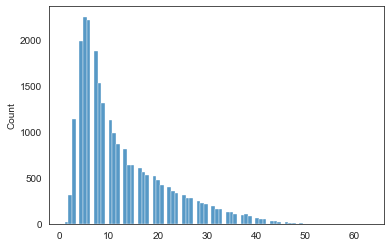

In [4]:
sns.set_style('white')
sns.histplot([len(seq) for seq in train_data])
plt.show()

In [9]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers, metrics, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [20]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = \
    train_test_split(train_data, np.array(train_label), test_size=0.3, stratify=train_label)

In [21]:
from collections import Counter

tokens = []

for tokens_list in train_X:
    tokens.extend(tokens_list)

tokens_counted = Counter(tokens)

num_all_token = len(tokens_counted)
num_rare_token = 0

for token, count in tokens_counted.items():
    if count == 1:
        num_rare_token += 1

print('- 중복 제거한 전체 형태소의 수 :', num_all_token)
print('- 출현 횟수가 1회인 희귀 형태소의 수 :', num_rare_token)

print('- 중복 제거한 전체 형태소 중 희귀 형태소의 비율 :', (num_rare_token / num_all_token) * 100)
print('- 중복 포함한 전체 형태소 중 희귀 형태소 출현 횟수의 비율 :', (num_rare_token / len(tokens)) * 100)

- 중복 제거한 전체 형태소의 수 : 13782
- 출현 횟수가 1회인 희귀 형태소의 수 : 6640
- 중복 제거한 전체 형태소 중 희귀 형태소의 비율 : 48.17878392105645
- 중복 포함한 전체 형태소 중 희귀 형태소 출현 횟수의 비율 : 3.024133863467643


In [22]:
vocab_size = num_all_token - num_rare_token + 2

print('어휘 목록(token vocabulary)의 크기 :', vocab_size)

어휘 목록(token vocabulary)의 크기 : 7144


In [23]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # tensorflow.keras.preprocessing.text.Tokenizer @ https://keras.io/ko/preprocessing/text/
# "num_words" : 단어 빈도에 따른 사용할 단어 개수의 최대값 (가장 빈번하게 사용되는 num_words 개의 단어만 보존) 
# -> 출현 빈도 내림차순으로 16475 개의 token만 유지 
# "oov_token" : oov_token parameter에 특정한 문자열 값이 지정된 경우, 해당 문자열이 단어 색인(word_index)에 추가되어 texts_to_sequences() 호출 과정에서 어휘 목록 외의 단어를 대체합니다.
# -> 추후 새로운 문자열에 대해 predict 과정을 진행할 때, training data에 포함되어있지 않은 단어(형태소)를 대상으로 매칭되어 sequence 처리 & predict가 가능하도록 해줍니다. (+ 출현 횟수 1회 형태소 처리)

tokenizer.fit_on_texts(train_X) # only "training" data

# reviews_df['reviews']에 포함된 전체 형태소들에 대해 임의의 Sequence number들과 1:1로 매칭시켜 변환
# -> Sequence number는 "0"이 아닌 "1"부터 시작 ("0"은 추후 나올 padding으로 추가될 0을 위해 활용)
train_sequences = tokenizer.texts_to_sequences(train_X) 
test_sequences = tokenizer.texts_to_sequences(val_X) 

# [ 형태소 : Sequence number ]로 이루어진 dict
word_vocab = tokenizer.word_index

In [ ]:
len_nums = []

for idx, sublist in enumerate(train_sequences):
    len_nums.append([idx, len(sublist)])

print('longest sentence (index num & sequence length) :', sorted(len_nums, key=lambda x:x[1], reverse=True)[0], '\n')

print(train_sequences[5779])
print(len(train_sequences[5779]))

print(train_X.iloc[5779])
print(len(train_X.iloc[5779]))

In [ ]:
MAX_LENGTH = 60 # >= longest sequence length

train_inputs = pad_sequences(train_sequences, 
                             maxlen=MAX_LENGTH, 
                             padding='post') # truncating='pre' <- 길이 초과 시 default로 앞의 데이터를 잘라서 버림

test_inputs = pad_sequences(test_sequences, 
                             maxlen=MAX_LENGTH, 
                             padding='post') # truncating='pre' <- 길이 초과 시 default로 앞의 데이터를 잘라서 버림

print(train_inputs.shape)

(17500, 60)


In [25]:
VOCAB_SIZE = vocab_size # num_all_token - num_rare_token + 2 
MAX_LENGTH = 60 # >= longest sequence length
NUM_CLASSES = len(set(train_y)) # number of classes

print(VOCAB_SIZE)
print(MAX_LENGTH)
print(NUM_CLASSES)

7144
60
4


In [26]:
model = models.Sequential()

model.add(layers.Embedding(input_dim=VOCAB_SIZE, output_dim=32, input_length=MAX_LENGTH)) # 3-dimensional cube image @ https://j.mp/2ZjrRno
# VOCAB_SIZE == 16475 / dimension of the embedding vector == 32 / MAX_LENGTH == 50
# - input (2D tensor) : (batch_size == # of sequences, input_length == 50) 
# - output (3D tensor) : (batch_size == # of sequences, input_length == 50, output_dim == 32)
# -> Embedding layer는 각 단어에 대해 "훈련 가능한" 하나의 벡터를 저장 (훈련 후 유사한 의미를 가진 단어는 종종 비슷한 벡터를 갖게 됨)
# ->> One-hot vector vs Embedding vector @ https://wikidocs.net/33520 + Vector embeddings @ https://j.mp/3kDOX0w

model.add(layers.GlobalAveragePooling1D()) # 다음 셀 예제 참고 & 공식문서 참고 @ https://j.mp/3kzXrWr
# - input (3D tensor) : (batch_size == # of sequences, input_length == 50, output_dim == 32)
# - output (2D tensor) : (batch_size == # of sequences, output_dim == 32) 
# -> 2번째 차원(sentence 당 sequence number 개수 50) 방향으로 평균을 계산하여 (None, 50, 32) -> (None, 32) 의 배열 생성
# ->> 이를 통해 추후 입력으로 사용되는 sentence에 포함된 sequence number의 개수가 달라지더라도 (ex. test data로 들어오는 문장의 단어 개수가 50이 아닐 때)
# ->>> 같은 크기(None, 32)의 벡터로 변환하여 통과시킬 수 있게 됨 (길이가 다른 입력을 다루기 위한 도구)

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer=optimizers.Adam(),
              metrics=[metrics.SparseCategoricalAccuracy()])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 32)            228608    
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 233,348
Trainable params: 233,348
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
import os

checkpoint_path = 'model/bi-lstm'

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

callback_checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path + 'best_model.h5', 
                                                monitor='val_sparse_categorical_accuracy',
                                                save_best_only=True, 
                                                verbose=1)

history = model.fit(train_inputs, train_y, validation_split=0.2,
                    epochs=15, batch_size=100,
                    verbose=1, callbacks=[callback_checkpoint])

Epoch 1/15


2022-07-12 21:04:18.502446: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-12 21:04:19.189927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - ETA: 0s - loss: 0.4601 - sparse_categorical_accuracy: 0.3202

2022-07-12 21:04:24.302463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.31857, saving model to model/bi-lstmbest_model.h5
140/140 [==============================] - 6s 35ms/step - loss: 0.4601 - sparse_categorical_accuracy: 0.3202 - val_loss: 0.3570 - val_sparse_categorical_accuracy: 0.3186
Epoch 2/15
138/140 [============================>.] - ETA: 0s - loss: 0.3503 - sparse_categorical_accuracy: 0.3204
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.31857
140/140 [==============================] - 4s 28ms/step - loss: 0.3506 - sparse_categorical_accuracy: 0.3204 - val_loss: 0.3467 - val_sparse_categorical_accuracy: 0.3186
Epoch 3/15
140/140 [==============================] - ETA: 0s - loss: 0.3468 - sparse_categorical_accuracy: 0.3204
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.31857
140/140 [==============================] - 4s 26ms/step - loss: 0.3468 - sparse_categorical_accuracy: 0.3204 - val_loss: 0.3380 - val_sparse_categorical_accuracy: 0.3186
Epoc

In [28]:
best_model = models.load_model(checkpoint_path + 'best_model.h5')

pred = best_model.predict(test_inputs)
pred = tf.argmax(pred, axis=1)

print(accuracy_score(pred, val_y)) 

  1/235 [..............................] - ETA: 1:59

2022-07-12 21:06:03.519611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 1s 4ms/step
0.32


## GRU

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)
train.head()

(25000, 3)


,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


In [4]:
train_data, test_data = train.copy(), test.copy()

In [5]:
print(train_data.groupby('target').size().reset_index(name = 'count'))

   target  count
0       1   4500
1       2   8000
2       4   2500
3       5  10000


In [6]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id         0
reviews    0
target     0
dtype: int64


/var/folders/md/nkdcc_y53654tkfkhydnl1g00000gn/T/ipykernel_28195/2891514628.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [7]:
# test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
# test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
# test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 25000


/var/folders/md/nkdcc_y53654tkfkhydnl1g00000gn/T/ipykernel_28195/3945388277.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [8]:
okt = Okt()
stop_words = stopwords.words('korean')

train_data['tokenized'] = train_data['reviews'].apply(lambda x: okt.morphs(x, stem=True))
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stop_words])
test_data['tokenized'] = test_data['reviews'].apply(lambda x: okt.morphs(x, stem=True))
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stop_words])

In [9]:
negative_words = np.hstack(train_data[(train_data.target == 1) | (train_data.target == 2)]['tokenized'].values)
positive_words = np.hstack(train_data[(train_data.target == 4) | (train_data.target == 5)]['tokenized'].values)

In [10]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('너무', 2168), ('안', 1998), ('요', 1978), ('보다', 1598), ('배송', 1541), ('없다', 1452), ('그냥', 1395), ('좋다', 1348), ('않다', 1282), ('오다', 1120), ('이다', 1050), ('되다', 1043), ('쓰다', 1021), ('별로', 950), ('사다', 923), ('생각', 871), ('아니다', 858), ('제품', 857), ('못', 854), ('자다', 852)]


In [11]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋다', 6148), ('배송', 1984), ('자다', 1713), ('너무', 1548), ('재다', 1469), ('먹다', 1431), ('보다', 1373), ('빠르다', 1283), ('구매', 1164), ('요', 1066), ('잘', 1009), ('사용', 906), ('이다', 847), ('쓰다', 837), ('가격', 837), ('사다', 775), ('만족하다', 772), ('맛있다', 757), ('되다', 715), ('않다', 709)]


긍정 리뷰의 평균 길이 : 12.36464
부정 리뷰의 평균 길이 : 9.35232


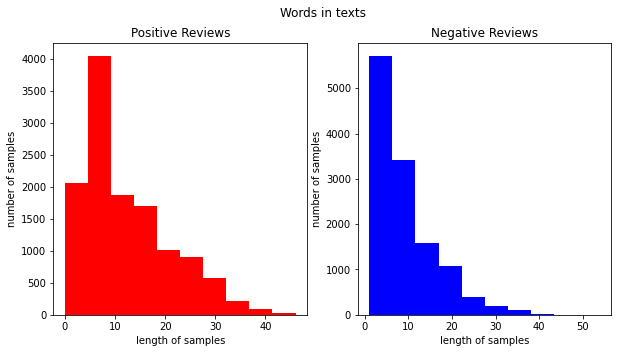

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[(train_data.target == 1) | (train_data.target == 2)]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[(train_data.target == 4) | (train_data.target == 5)]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [13]:
X_train = train_data['tokenized'].values
y_train = train_data['target'].values
X_test= test_data['tokenized'].values
# y_test = test_data['target'].values

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [15]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 15202
등장 빈도가 1번 이하인 희귀 단어의 수: 7129
단어 집합에서 희귀 단어의 비율: 46.89514537560847
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.626150253074095


In [16]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 8075


In [17]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
print(X_train[:3])

[[2, 98, 78, 57, 296, 5], [23, 6, 7, 8, 164, 590, 305, 243, 481, 8, 164, 35, 888, 2086, 102, 1077, 3, 212], [100, 45, 53, 958, 89, 132, 474, 26, 53, 220, 761, 958, 89, 55, 131, 22, 790, 4, 388, 320, 276]]


리뷰의 최대 길이 : 54
리뷰의 평균 길이 : 10.85848


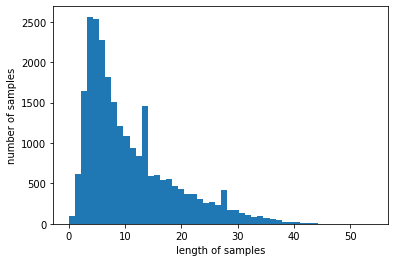

In [19]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
max_len = 60
X_train = pad_sequences(X_train, maxlen=max_len, truncating='post', padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, truncating='post', padding='post')

In [21]:
X_train[0]

array([  2,  98,  78,  57, 296,   5,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [22]:
X_train.shape, y_train.shape, X_test.shape

((25000, 60), (25000,), (25000, 60))

In [23]:
np.save('data/X_train', X_train)
np.save('data/y_train', y_train)
np.save('data/X_test', X_test)

In [25]:
import numpy as np

X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
X_test = np.load('data/X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((25000, 60), (25000,), (25000, 60))

In [26]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_train = y_train[:,[1,2,4,5]]
y_train.shape

(25000, 4)

In [43]:
from tensorflow_addons.metrics import F1Score

In [53]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(4, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('model/gru/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[F1Score(num_classes=4), 'accuracy'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=100, validation_split=0.2)

Epoch 1/15


2022-07-12 22:56:57.275999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 22:56:57.702338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 22:56:57.942769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 1.2782 - f1_score: 0.1426 - accuracy: 0.3991

2022-07-12 22:57:32.845852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 22:57:33.120921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.40380, saving model to model/gru/best_model.h5
200/200 [==============================] - 40s 191ms/step - loss: 1.2782 - f1_score: 0.1426 - accuracy: 0.3991 - val_loss: 1.2619 - val_f1_score: 0.1438 - val_accuracy: 0.4038
Epoch 2/15
200/200 [==============================] - ETA: 0s - loss: 1.2739 - f1_score: 0.1707 - accuracy: 0.3942
Epoch 2: val_accuracy did not improve from 0.40380
200/200 [==============================] - 27s 136ms/step - loss: 1.2739 - f1_score: 0.1707 - accuracy: 0.3942 - val_loss: 1.2658 - val_f1_score: 0.1438 - val_accuracy: 0.4038
Epoch 3/15
200/200 [==============================] - ETA: 0s - loss: 1.2747 - f1_score: 0.1426 - accuracy: 0.3991
Epoch 3: val_accuracy did not improve from 0.40380
200/200 [==============================] - 29s 147ms/step - loss: 1.2747 - f1_score: 0.1426 - accuracy: 0.3991 - val_loss: 1.2627 - val_f1_score: 0.1438 - val_accuracy: 0.4038
Epoch 4/15
200/200 [==========================

In [54]:
from tensorflow.keras import models
import tensorflow as tf
best_model = models.load_model('model/gru/best_model.h5')

pred = best_model.predict(X_test)
# pred = tf.argmax(pred, axis=1)

2022-07-12 23:12:11.846386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 23:12:12.175923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 12s 13ms/step


In [55]:
set(np.argmax(pred, axis=1).tolist())

{3}

In [27]:
submission = pd.read_csv("data/sample_submission.csv") 
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [28]:
submission['target'] = pred
submission.head()

,id,target
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2


In [29]:
submission['target'].unique()

array([2])